Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle -Uqq
!mkdir /root/.kaggle
!mkdir model_checkpoints
!cp /content/drive/MyDrive/kaggle.json  /root/.kaggle

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:
!cp /content/drive/MyDrive/kaggle.json  /root/.kaggle

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:

!pip install wandb -Uqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
 94% 101M/107M [00:01<00:00, 123MB/s]  
100% 107M/107M [00:01<00:00, 104MB/s]


In [ ]:
!mkdir data
!unzip -d data -q /content/brian-tumor-dataset.zip
!rm -rf /content/brian-tumor-dataset.zip

In [ ]:
import pandas as pd

In [ ]:
metadata = pd.read_csv("/content/data/metadata.csv")
metadata_rgb = pd.read_csv("/content/data/metadata_rgb_only.csv")

In [ ]:
metadata

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"
...,...,...,...,...,...,...
4595,4595,Not Cancer (995).jpg,normal,JPEG,RGB,"(168, 300, 3)"
4596,4596,Not Cancer (996).jpg,normal,JPEG,RGB,"(509, 452, 3)"
4597,4597,Not Cancer (997).jpg,normal,JPEG,RGB,"(197, 177, 3)"
4598,4598,Not Cancer (998).jpg,normal,JPEG,RGB,"(217, 232, 3)"


In [ ]:
metadata_rgb

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
2,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
3,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"
4,5,Cancer (100).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
...,...,...,...,...,...,...
4456,4595,Not Cancer (995).jpg,normal,JPEG,RGB,"(168, 300, 3)"
4457,4596,Not Cancer (996).jpg,normal,JPEG,RGB,"(509, 452, 3)"
4458,4597,Not Cancer (997).jpg,normal,JPEG,RGB,"(197, 177, 3)"
4459,4598,Not Cancer (998).jpg,normal,JPEG,RGB,"(217, 232, 3)"


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import wandb
from wandb.keras import WandbCallback
from pathlib import Path

In [ ]:
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
path = Path('/content/data/Brain Tumor Data Set/Brain Tumor Data Set')
batch_size = 32
img_height = 224
img_width = 224

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="both",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4514 files belonging to 2 classes.
Using 3612 files for training.
Using 902 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Brain Tumor', 'Healthy']


In [ ]:
tf.keras.backend.clear_session()

resnet_base = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='avg',
)
rescaling = layers.Rescaling(1.0 / 255)
resize = layers.Resizing(img_height, img_width)

model = Sequential()
#rescale and resize the image
model.add(resize)
model.add(rescaling)

model.add(resnet_base)
model.add(layers.Dense(1, activation='sigmoid'))

#freeze the base resnet_base from model
resnet_base.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
batch = next(iter(train_ds))
outputs = model(batch[0])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (32, 224, 224, 3)         0         
                                                                 
 rescaling (Rescaling)       (32, 224, 224, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (32, 1)                   2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()
roc_auc = tf.keras.metrics.AUC(curve='ROC', name='roc_auc')
accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy')

In [ ]:
# define callbacks
decay_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
checkpoint_filepath = "/content/model_checkpoints/models_resnet_50/model_{epoch:02d}_val_roc_auc_{val_roc_auc:.4f}_val_loss_{val_loss:.4f}_val_accuracy_{val_accuracy:.4f}.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
)

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=[roc_auc, accuracy])

In [ ]:
from google.colab import userdata
WANDB_API_KEY = userdata.get('wandb_api')

In [ ]:
wandb.login(key=WANDB_API_KEY)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!wandb login --relogin


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

# Replace 'your-api-key' with your actual W&B API key
wandb.login(key='14490665281cfce57ebb93f7fbc543f719e0c014')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
run = wandb.init(project="combined", entity="shivanikotian18", job_type="finetune", group='resnet',tags=['ResNet50'])
assert run is wandb.run, "Something went wrong"
#train and validate the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[checkpoint, WandbCallback(save_weights_only=False)],
)
run.finish()

wandb: Currently logged in as: shivanikotian18. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/40
113/113 [==============================] - ETA: 0s - loss: 0.6626 - roc_auc: 0.6429 - accuracy: 0.6262

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 41s 309ms/step - loss: 0.6626 - roc_auc: 0.6429 - accuracy: 0.6262 - val_loss: 0.6365 - val_roc_auc: 0.7275 - val_accuracy: 0.6652
Epoch 2/40
113/113 [==============================] - ETA: 0s - loss: 0.6114 - roc_auc: 0.7316 - accuracy: 0.6852

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 33s 286ms/step - loss: 0.6114 - roc_auc: 0.7316 - accuracy: 0.6852 - val_loss: 0.6038 - val_roc_auc: 0.7429 - val_accuracy: 0.7106
Epoch 3/40
113/113 [==============================] - ETA: 0s - loss: 0.5911 - roc_auc: 0.7477 - accuracy: 0.7076

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 33s 286ms/step - loss: 0.5911 - roc_auc: 0.7477 - accuracy: 0.7076 - val_loss: 0.5912 - val_roc_auc: 0.7583 - val_accuracy: 0.7095
Epoch 4/40
113/113 [==============================] - ETA: 0s - loss: 0.5785 - roc_auc: 0.7599 - accuracy: 0.7065

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 36s 313ms/step - loss: 0.5785 - roc_auc: 0.7599 - accuracy: 0.7065 - val_loss: 0.5846 - val_roc_auc: 0.7690 - val_accuracy: 0.7062
Epoch 5/40
113/113 [==============================] - ETA: 0s - loss: 0.5701 - roc_auc: 0.7673 - accuracy: 0.7207

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 33s 286ms/step - loss: 0.5701 - roc_auc: 0.7673 - accuracy: 0.7207 - val_loss: 0.5651 - val_roc_auc: 0.7773 - val_accuracy: 0.7206
Epoch 6/40
113/113 [==============================] - ETA: 0s - loss: 0.5589 - roc_auc: 0.7820 - accuracy: 0.7312

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 34s 298ms/step - loss: 0.5589 - roc_auc: 0.7820 - accuracy: 0.7312 - val_loss: 0.5584 - val_roc_auc: 0.7862 - val_accuracy: 0.7239
Epoch 7/40
113/113 [==============================] - ETA: 0s - loss: 0.5521 - roc_auc: 0.7905 - accuracy: 0.7331

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.3s


113/113 [==============================] - 34s 297ms/step - loss: 0.5521 - roc_auc: 0.7905 - accuracy: 0.7331 - val_loss: 0.5512 - val_roc_auc: 0.7932 - val_accuracy: 0.7284
Epoch 8/40
113/113 [==============================] - 15s 127ms/step - loss: 0.5479 - roc_auc: 0.7934 - accuracy: 0.7342 - val_loss: 0.5519 - val_roc_auc: 0.7992 - val_accuracy: 0.7339
Epoch 9/40
113/113 [==============================] - ETA: 0s - loss: 0.5404 - roc_auc: 0.8040 - accuracy: 0.7398

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 33s 292ms/step - loss: 0.5404 - roc_auc: 0.8040 - accuracy: 0.7398 - val_loss: 0.5415 - val_roc_auc: 0.8038 - val_accuracy: 0.7317
Epoch 10/40
113/113 [==============================] - ETA: 0s - loss: 0.5403 - roc_auc: 0.8025 - accuracy: 0.7414

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 34s 295ms/step - loss: 0.5403 - roc_auc: 0.8025 - accuracy: 0.7414 - val_loss: 0.5388 - val_roc_auc: 0.8087 - val_accuracy: 0.7295
Epoch 11/40
113/113 [==============================] - ETA: 0s - loss: 0.5329 - roc_auc: 0.8150 - accuracy: 0.7434

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.3s


113/113 [==============================] - 34s 295ms/step - loss: 0.5329 - roc_auc: 0.8150 - accuracy: 0.7434 - val_loss: 0.5329 - val_roc_auc: 0.8127 - val_accuracy: 0.7417
Epoch 12/40
113/113 [==============================] - 15s 128ms/step - loss: 0.5289 - roc_auc: 0.8158 - accuracy: 0.7511 - val_loss: 0.5350 - val_roc_auc: 0.8169 - val_accuracy: 0.7262
Epoch 13/40
113/113 [==============================] - ETA: 0s - loss: 0.5243 - roc_auc: 0.8181 - accuracy: 0.7481

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.3s


113/113 [==============================] - 36s 322ms/step - loss: 0.5243 - roc_auc: 0.8181 - accuracy: 0.7481 - val_loss: 0.5298 - val_roc_auc: 0.8201 - val_accuracy: 0.7228
Epoch 14/40
113/113 [==============================] - ETA: 0s - loss: 0.5215 - roc_auc: 0.8247 - accuracy: 0.7514

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.3s


113/113 [==============================] - 34s 295ms/step - loss: 0.5215 - roc_auc: 0.8247 - accuracy: 0.7514 - val_loss: 0.5258 - val_roc_auc: 0.8221 - val_accuracy: 0.7583
Epoch 15/40
113/113 [==============================] - ETA: 0s - loss: 0.5169 - roc_auc: 0.8287 - accuracy: 0.7547

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 33s 293ms/step - loss: 0.5169 - roc_auc: 0.8287 - accuracy: 0.7547 - val_loss: 0.5216 - val_roc_auc: 0.8253 - val_accuracy: 0.7517
Epoch 16/40
113/113 [==============================] - ETA: 0s - loss: 0.5149 - roc_auc: 0.8337 - accuracy: 0.7503

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 34s 298ms/step - loss: 0.5149 - roc_auc: 0.8337 - accuracy: 0.7503 - val_loss: 0.5190 - val_roc_auc: 0.8281 - val_accuracy: 0.7627
Epoch 17/40
113/113 [==============================] - ETA: 0s - loss: 0.5133 - roc_auc: 0.8334 - accuracy: 0.7542

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 34s 301ms/step - loss: 0.5133 - roc_auc: 0.8334 - accuracy: 0.7542 - val_loss: 0.5163 - val_roc_auc: 0.8312 - val_accuracy: 0.7616
Epoch 18/40
113/113 [==============================] - 15s 126ms/step - loss: 0.5093 - roc_auc: 0.8348 - accuracy: 0.7547 - val_loss: 0.5184 - val_roc_auc: 0.8325 - val_accuracy: 0.7339
Epoch 19/40
113/113 [==============================] - ETA: 0s - loss: 0.5064 - roc_auc: 0.8401 - accuracy: 0.7597

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.3s


113/113 [==============================] - 34s 298ms/step - loss: 0.5064 - roc_auc: 0.8401 - accuracy: 0.7597 - val_loss: 0.5111 - val_roc_auc: 0.8346 - val_accuracy: 0.7616
Epoch 20/40
113/113 [==============================] - ETA: 0s - loss: 0.5038 - roc_auc: 0.8444 - accuracy: 0.7586

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.5s


113/113 [==============================] - 33s 293ms/step - loss: 0.5038 - roc_auc: 0.8444 - accuracy: 0.7586 - val_loss: 0.5093 - val_roc_auc: 0.8366 - val_accuracy: 0.7616
Epoch 21/40
113/113 [==============================] - 17s 147ms/step - loss: 0.5000 - roc_auc: 0.8479 - accuracy: 0.7583 - val_loss: 0.5128 - val_roc_auc: 0.8381 - val_accuracy: 0.7605
Epoch 22/40
113/113 [==============================] - ETA: 0s - loss: 0.4980 - roc_auc: 0.8472 - accuracy: 0.7636

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.5s


113/113 [==============================] - 37s 329ms/step - loss: 0.4980 - roc_auc: 0.8472 - accuracy: 0.7636 - val_loss: 0.5066 - val_roc_auc: 0.8403 - val_accuracy: 0.7694
Epoch 23/40
113/113 [==============================] - ETA: 0s - loss: 0.4975 - roc_auc: 0.8462 - accuracy: 0.7605

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 33s 287ms/step - loss: 0.4975 - roc_auc: 0.8462 - accuracy: 0.7605 - val_loss: 0.5035 - val_roc_auc: 0.8414 - val_accuracy: 0.7672
Epoch 24/40
113/113 [==============================] - ETA: 0s - loss: 0.4912 - roc_auc: 0.8540 - accuracy: 0.7658

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.3s


113/113 [==============================] - 34s 298ms/step - loss: 0.4912 - roc_auc: 0.8540 - accuracy: 0.7658 - val_loss: 0.5026 - val_roc_auc: 0.8433 - val_accuracy: 0.7494
Epoch 25/40
113/113 [==============================] - ETA: 0s - loss: 0.4908 - roc_auc: 0.8551 - accuracy: 0.7652

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 33s 288ms/step - loss: 0.4908 - roc_auc: 0.8551 - accuracy: 0.7652 - val_loss: 0.5020 - val_roc_auc: 0.8443 - val_accuracy: 0.7650
Epoch 26/40
113/113 [==============================] - ETA: 0s - loss: 0.4910 - roc_auc: 0.8536 - accuracy: 0.7633

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.3s


113/113 [==============================] - 33s 290ms/step - loss: 0.4910 - roc_auc: 0.8536 - accuracy: 0.7633 - val_loss: 0.4975 - val_roc_auc: 0.8458 - val_accuracy: 0.7650
Epoch 27/40
113/113 [==============================] - ETA: 0s - loss: 0.4861 - roc_auc: 0.8579 - accuracy: 0.7680

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 34s 297ms/step - loss: 0.4861 - roc_auc: 0.8579 - accuracy: 0.7680 - val_loss: 0.4971 - val_roc_auc: 0.8471 - val_accuracy: 0.7528
Epoch 28/40
113/113 [==============================] - 15s 126ms/step - loss: 0.4842 - roc_auc: 0.8596 - accuracy: 0.7691 - val_loss: 0.5018 - val_roc_auc: 0.8479 - val_accuracy: 0.7594
Epoch 29/40
113/113 [==============================] - ETA: 0s - loss: 0.4818 - roc_auc: 0.8639 - accuracy: 0.7727

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.5s


113/113 [==============================] - 33s 294ms/step - loss: 0.4818 - roc_auc: 0.8639 - accuracy: 0.7727 - val_loss: 0.4937 - val_roc_auc: 0.8488 - val_accuracy: 0.7683
Epoch 30/40
113/113 [==============================] - 17s 147ms/step - loss: 0.4836 - roc_auc: 0.8584 - accuracy: 0.7636 - val_loss: 0.4958 - val_roc_auc: 0.8501 - val_accuracy: 0.7472
Epoch 31/40
113/113 [==============================] - ETA: 0s - loss: 0.4779 - roc_auc: 0.8648 - accuracy: 0.7719

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.3s


113/113 [==============================] - 33s 290ms/step - loss: 0.4779 - roc_auc: 0.8648 - accuracy: 0.7719 - val_loss: 0.4896 - val_roc_auc: 0.8515 - val_accuracy: 0.7716
Epoch 32/40
113/113 [==============================] - ETA: 0s - loss: 0.4788 - roc_auc: 0.8612 - accuracy: 0.7663

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.5s


113/113 [==============================] - 33s 290ms/step - loss: 0.4788 - roc_auc: 0.8612 - accuracy: 0.7663 - val_loss: 0.4884 - val_roc_auc: 0.8520 - val_accuracy: 0.7705
Epoch 33/40
113/113 [==============================] - 15s 128ms/step - loss: 0.4757 - roc_auc: 0.8664 - accuracy: 0.7752 - val_loss: 0.4903 - val_roc_auc: 0.8528 - val_accuracy: 0.7517
Epoch 34/40
113/113 [==============================] - 15s 129ms/step - loss: 0.4718 - roc_auc: 0.8695 - accuracy: 0.7741 - val_loss: 0.4917 - val_roc_auc: 0.8535 - val_accuracy: 0.7716
Epoch 35/40
113/113 [==============================] - ETA: 0s - loss: 0.4709 - roc_auc: 0.8697 - accuracy: 0.7749

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 33s 295ms/step - loss: 0.4709 - roc_auc: 0.8697 - accuracy: 0.7749 - val_loss: 0.4846 - val_roc_auc: 0.8550 - val_accuracy: 0.7716
Epoch 36/40
113/113 [==============================] - ETA: 0s - loss: 0.4735 - roc_auc: 0.8640 - accuracy: 0.7735

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 33s 288ms/step - loss: 0.4735 - roc_auc: 0.8640 - accuracy: 0.7735 - val_loss: 0.4826 - val_roc_auc: 0.8558 - val_accuracy: 0.7783
Epoch 37/40
113/113 [==============================] - ETA: 0s - loss: 0.4763 - roc_auc: 0.8591 - accuracy: 0.7774

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 34s 298ms/step - loss: 0.4763 - roc_auc: 0.8591 - accuracy: 0.7774 - val_loss: 0.4818 - val_roc_auc: 0.8561 - val_accuracy: 0.7761
Epoch 38/40
113/113 [==============================] - ETA: 0s - loss: 0.4663 - roc_auc: 0.8710 - accuracy: 0.7807

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.9s


113/113 [==============================] - 33s 292ms/step - loss: 0.4663 - roc_auc: 0.8710 - accuracy: 0.7807 - val_loss: 0.4808 - val_roc_auc: 0.8572 - val_accuracy: 0.7749
Epoch 39/40
113/113 [==============================] - 15s 126ms/step - loss: 0.4633 - roc_auc: 0.8763 - accuracy: 0.7796 - val_loss: 0.4853 - val_roc_auc: 0.8580 - val_accuracy: 0.7805
Epoch 40/40
113/113 [==============================] - ETA: 0s - loss: 0.4633 - roc_auc: 0.8749 - accuracy: 0.7802

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_232316-4e18ou2h/files/model-best)... Done. 0.4s


113/113 [==============================] - 34s 300ms/step - loss: 0.4633 - roc_auc: 0.8749 - accuracy: 0.7802 - val_loss: 0.4776 - val_roc_auc: 0.8592 - val_accuracy: 0.7816


accuracy,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
roc_auc,▁▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████▇███
val_accuracy,▁▄▄▃▄▅▅▅▅▅▆▅▄▇▆▇▇▅▇▇▇▇▇▆▇▇▆▇▇▆▇▇▆▇▇█████
val_loss,█▇▆▆▅▅▄▄▄▄▃▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
val_roc_auc,▁▂▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
accuracy,0.78018
best_epoch,39
best_val_loss,0.47764
epoch,39


In [ ]:
tf.keras.backend.clear_session()
VGG_model = Sequential()

pretrained_model= keras.applications.VGG19(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')

rescaling = layers.Rescaling(1.0 / 255)
resize = layers.Resizing(img_height, img_width)

#rescale and resize the image
VGG_model.add(resize)
VGG_model.add(rescaling)
VGG_model.add(pretrained_model)


VGG_model.add(Dense(1, activation='sigmoid'))
pretrained_model.trainable=False

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
batch = next(iter(train_ds))
outputs = VGG_model(batch[0])
VGG_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (32, 224, 224, 3)         0         
                                                                 
 rescaling (Rescaling)       (32, 224, 224, 3)         0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (32, 1)                   513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()
roc_auc = tf.keras.metrics.AUC(curve='ROC', name='roc_auc')
accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy')

In [ ]:
VGG_model.compile(optimizer=optimizer, loss=loss, metrics=[roc_auc, accuracy])

In [ ]:
# define callbacks
decay_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

checkpoint_filepath_vgg = "/content/model_checkpoints/models_vgg_19/model_{epoch:02d}_val_roc_auc_{val_roc_auc:.4f}_val_loss_{val_loss:.4f}_val_accuracy_{val_accuracy:.4f}.keras"
checkpoint_vgg = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_vgg,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
)

In [ ]:
run_vgg = wandb.init(project="combined", entity="shivanikotian18", job_type="finetune", group='vgg',tags=['VGG19'])
#train and validate the model
history = VGG_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[checkpoint_vgg, WandbCallback(save_weights_only=False)],
)
run_vgg.finish()

Epoch 1/40
113/113 [==============================] - ETA: 0s - loss: 0.6801 - roc_auc: 0.5979 - accuracy: 0.5681

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 29s 245ms/step - loss: 0.6801 - roc_auc: 0.5979 - accuracy: 0.5681 - val_loss: 0.6486 - val_roc_auc: 0.8205 - val_accuracy: 0.7350
Epoch 2/40
113/113 [==============================] - ETA: 0s - loss: 0.6230 - roc_auc: 0.7970 - accuracy: 0.7049

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 27s 232ms/step - loss: 0.6230 - roc_auc: 0.7970 - accuracy: 0.7049 - val_loss: 0.6048 - val_roc_auc: 0.8432 - val_accuracy: 0.7627
Epoch 3/40
113/113 [==============================] - ETA: 0s - loss: 0.5838 - roc_auc: 0.8358 - accuracy: 0.7422

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 27s 239ms/step - loss: 0.5838 - roc_auc: 0.8358 - accuracy: 0.7422 - val_loss: 0.5713 - val_roc_auc: 0.8544 - val_accuracy: 0.7738
Epoch 4/40
113/113 [==============================] - ETA: 0s - loss: 0.5551 - roc_auc: 0.8498 - accuracy: 0.7658

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 236ms/step - loss: 0.5551 - roc_auc: 0.8498 - accuracy: 0.7658 - val_loss: 0.5449 - val_roc_auc: 0.8635 - val_accuracy: 0.7805
Epoch 5/40
113/113 [==============================] - ETA: 0s - loss: 0.5306 - roc_auc: 0.8648 - accuracy: 0.7788

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 239ms/step - loss: 0.5306 - roc_auc: 0.8648 - accuracy: 0.7788 - val_loss: 0.5241 - val_roc_auc: 0.8710 - val_accuracy: 0.7894
Epoch 6/40
113/113 [==============================] - ETA: 0s - loss: 0.5131 - roc_auc: 0.8694 - accuracy: 0.7885

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 26s 229ms/step - loss: 0.5131 - roc_auc: 0.8694 - accuracy: 0.7885 - val_loss: 0.5105 - val_roc_auc: 0.8785 - val_accuracy: 0.7916
Epoch 7/40
113/113 [==============================] - ETA: 0s - loss: 0.4961 - roc_auc: 0.8782 - accuracy: 0.7957

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 235ms/step - loss: 0.4961 - roc_auc: 0.8782 - accuracy: 0.7957 - val_loss: 0.4940 - val_roc_auc: 0.8842 - val_accuracy: 0.7960
Epoch 8/40
113/113 [==============================] - ETA: 0s - loss: 0.4825 - roc_auc: 0.8842 - accuracy: 0.7998

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 238ms/step - loss: 0.4825 - roc_auc: 0.8842 - accuracy: 0.7998 - val_loss: 0.4804 - val_roc_auc: 0.8891 - val_accuracy: 0.7960
Epoch 9/40
113/113 [==============================] - ETA: 0s - loss: 0.4700 - roc_auc: 0.8893 - accuracy: 0.8034

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 26s 231ms/step - loss: 0.4700 - roc_auc: 0.8893 - accuracy: 0.8034 - val_loss: 0.4749 - val_roc_auc: 0.8939 - val_accuracy: 0.8060
Epoch 10/40
113/113 [==============================] - ETA: 0s - loss: 0.4588 - roc_auc: 0.8953 - accuracy: 0.8084

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 232ms/step - loss: 0.4588 - roc_auc: 0.8953 - accuracy: 0.8084 - val_loss: 0.4585 - val_roc_auc: 0.8983 - val_accuracy: 0.8104
Epoch 11/40
113/113 [==============================] - ETA: 0s - loss: 0.4496 - roc_auc: 0.8979 - accuracy: 0.8120

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 28s 244ms/step - loss: 0.4496 - roc_auc: 0.8979 - accuracy: 0.8120 - val_loss: 0.4524 - val_roc_auc: 0.9016 - val_accuracy: 0.8126
Epoch 12/40
113/113 [==============================] - ETA: 0s - loss: 0.4402 - roc_auc: 0.9030 - accuracy: 0.8156

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 238ms/step - loss: 0.4402 - roc_auc: 0.9030 - accuracy: 0.8156 - val_loss: 0.4422 - val_roc_auc: 0.9055 - val_accuracy: 0.8204
Epoch 13/40
113/113 [==============================] - ETA: 0s - loss: 0.4318 - roc_auc: 0.9068 - accuracy: 0.8184

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 26s 232ms/step - loss: 0.4318 - roc_auc: 0.9068 - accuracy: 0.8184 - val_loss: 0.4333 - val_roc_auc: 0.9090 - val_accuracy: 0.8237
Epoch 14/40
113/113 [==============================] - ETA: 0s - loss: 0.4248 - roc_auc: 0.9096 - accuracy: 0.8264

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 27s 234ms/step - loss: 0.4248 - roc_auc: 0.9096 - accuracy: 0.8264 - val_loss: 0.4305 - val_roc_auc: 0.9116 - val_accuracy: 0.8293
Epoch 15/40
113/113 [==============================] - ETA: 0s - loss: 0.4184 - roc_auc: 0.9118 - accuracy: 0.8261

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 27s 235ms/step - loss: 0.4184 - roc_auc: 0.9118 - accuracy: 0.8261 - val_loss: 0.4239 - val_roc_auc: 0.9142 - val_accuracy: 0.8326
Epoch 16/40
113/113 [==============================] - ETA: 0s - loss: 0.4107 - roc_auc: 0.9159 - accuracy: 0.8306

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 26s 230ms/step - loss: 0.4107 - roc_auc: 0.9159 - accuracy: 0.8306 - val_loss: 0.4163 - val_roc_auc: 0.9169 - val_accuracy: 0.8348
Epoch 17/40
113/113 [==============================] - ETA: 0s - loss: 0.4055 - roc_auc: 0.9178 - accuracy: 0.8328

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 236ms/step - loss: 0.4055 - roc_auc: 0.9178 - accuracy: 0.8328 - val_loss: 0.4086 - val_roc_auc: 0.9195 - val_accuracy: 0.8415
Epoch 18/40
113/113 [==============================] - ETA: 0s - loss: 0.3995 - roc_auc: 0.9197 - accuracy: 0.8383

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 233ms/step - loss: 0.3995 - roc_auc: 0.9197 - accuracy: 0.8383 - val_loss: 0.4062 - val_roc_auc: 0.9215 - val_accuracy: 0.8381
Epoch 19/40
113/113 [==============================] - ETA: 0s - loss: 0.3946 - roc_auc: 0.9221 - accuracy: 0.8378

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 26s 229ms/step - loss: 0.3946 - roc_auc: 0.9221 - accuracy: 0.8378 - val_loss: 0.3996 - val_roc_auc: 0.9232 - val_accuracy: 0.8470
Epoch 20/40
113/113 [==============================] - ETA: 0s - loss: 0.3887 - roc_auc: 0.9247 - accuracy: 0.8433

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 28s 241ms/step - loss: 0.3887 - roc_auc: 0.9247 - accuracy: 0.8433 - val_loss: 0.3932 - val_roc_auc: 0.9250 - val_accuracy: 0.8537
Epoch 21/40
113/113 [==============================] - ETA: 0s - loss: 0.3837 - roc_auc: 0.9264 - accuracy: 0.8472

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 28s 247ms/step - loss: 0.3837 - roc_auc: 0.9264 - accuracy: 0.8472 - val_loss: 0.3913 - val_roc_auc: 0.9266 - val_accuracy: 0.8415
Epoch 22/40
113/113 [==============================] - ETA: 0s - loss: 0.3791 - roc_auc: 0.9282 - accuracy: 0.8477

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 26s 228ms/step - loss: 0.3791 - roc_auc: 0.9282 - accuracy: 0.8477 - val_loss: 0.3850 - val_roc_auc: 0.9280 - val_accuracy: 0.8525
Epoch 23/40
113/113 [==============================] - ETA: 0s - loss: 0.3748 - roc_auc: 0.9303 - accuracy: 0.8502

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 237ms/step - loss: 0.3748 - roc_auc: 0.9303 - accuracy: 0.8502 - val_loss: 0.3807 - val_roc_auc: 0.9295 - val_accuracy: 0.8559
Epoch 24/40
113/113 [==============================] - ETA: 0s - loss: 0.3700 - roc_auc: 0.9320 - accuracy: 0.8571

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 235ms/step - loss: 0.3700 - roc_auc: 0.9320 - accuracy: 0.8571 - val_loss: 0.3794 - val_roc_auc: 0.9309 - val_accuracy: 0.8503
Epoch 25/40
113/113 [==============================] - ETA: 0s - loss: 0.3674 - roc_auc: 0.9325 - accuracy: 0.8524

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 28s 243ms/step - loss: 0.3674 - roc_auc: 0.9325 - accuracy: 0.8524 - val_loss: 0.3779 - val_roc_auc: 0.9319 - val_accuracy: 0.8448
Epoch 26/40
113/113 [==============================] - ETA: 0s - loss: 0.3638 - roc_auc: 0.9340 - accuracy: 0.8585

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 235ms/step - loss: 0.3638 - roc_auc: 0.9340 - accuracy: 0.8585 - val_loss: 0.3727 - val_roc_auc: 0.9334 - val_accuracy: 0.8514
Epoch 27/40
113/113 [==============================] - ETA: 0s - loss: 0.3588 - roc_auc: 0.9360 - accuracy: 0.8616

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 26s 228ms/step - loss: 0.3588 - roc_auc: 0.9360 - accuracy: 0.8616 - val_loss: 0.3679 - val_roc_auc: 0.9345 - val_accuracy: 0.8570
Epoch 28/40
113/113 [==============================] - 25s 216ms/step - loss: 0.3556 - roc_auc: 0.9369 - accuracy: 0.8643 - val_loss: 0.3685 - val_roc_auc: 0.9357 - val_accuracy: 0.8570
Epoch 29/40
113/113 [==============================] - ETA: 0s - loss: 0.3533 - roc_auc: 0.9375 - accuracy: 0.8643

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 27s 234ms/step - loss: 0.3533 - roc_auc: 0.9375 - accuracy: 0.8643 - val_loss: 0.3612 - val_roc_auc: 0.9367 - val_accuracy: 0.8603
Epoch 30/40
113/113 [==============================] - ETA: 0s - loss: 0.3482 - roc_auc: 0.9399 - accuracy: 0.8630

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 234ms/step - loss: 0.3482 - roc_auc: 0.9399 - accuracy: 0.8630 - val_loss: 0.3596 - val_roc_auc: 0.9375 - val_accuracy: 0.8636
Epoch 31/40
113/113 [==============================] - ETA: 0s - loss: 0.3460 - roc_auc: 0.9403 - accuracy: 0.8690

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 27s 235ms/step - loss: 0.3460 - roc_auc: 0.9403 - accuracy: 0.8690 - val_loss: 0.3546 - val_roc_auc: 0.9387 - val_accuracy: 0.8647
Epoch 32/40
113/113 [==============================] - 23s 201ms/step - loss: 0.3424 - roc_auc: 0.9418 - accuracy: 0.8685 - val_loss: 0.3549 - val_roc_auc: 0.9398 - val_accuracy: 0.8692
Epoch 33/40
113/113 [==============================] - ETA: 0s - loss: 0.3399 - roc_auc: 0.9425 - accuracy: 0.8693

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 28s 245ms/step - loss: 0.3399 - roc_auc: 0.9425 - accuracy: 0.8693 - val_loss: 0.3501 - val_roc_auc: 0.9407 - val_accuracy: 0.8670
Epoch 34/40
113/113 [==============================] - 24s 204ms/step - loss: 0.3369 - roc_auc: 0.9437 - accuracy: 0.8738 - val_loss: 0.3552 - val_roc_auc: 0.9414 - val_accuracy: 0.8636
Epoch 35/40
113/113 [==============================] - ETA: 0s - loss: 0.3344 - roc_auc: 0.9443 - accuracy: 0.8743

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.5s


113/113 [==============================] - 27s 235ms/step - loss: 0.3344 - roc_auc: 0.9443 - accuracy: 0.8743 - val_loss: 0.3430 - val_roc_auc: 0.9424 - val_accuracy: 0.8747
Epoch 36/40
113/113 [==============================] - 24s 211ms/step - loss: 0.3320 - roc_auc: 0.9446 - accuracy: 0.8765 - val_loss: 0.3446 - val_roc_auc: 0.9431 - val_accuracy: 0.8736
Epoch 37/40
113/113 [==============================] - ETA: 0s - loss: 0.3300 - roc_auc: 0.9457 - accuracy: 0.8743

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 233ms/step - loss: 0.3300 - roc_auc: 0.9457 - accuracy: 0.8743 - val_loss: 0.3428 - val_roc_auc: 0.9438 - val_accuracy: 0.8725
Epoch 38/40
113/113 [==============================] - ETA: 0s - loss: 0.3266 - roc_auc: 0.9470 - accuracy: 0.8751

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.4s


113/113 [==============================] - 27s 238ms/step - loss: 0.3266 - roc_auc: 0.9470 - accuracy: 0.8751 - val_loss: 0.3382 - val_roc_auc: 0.9446 - val_accuracy: 0.8747
Epoch 39/40
113/113 [==============================] - 24s 207ms/step - loss: 0.3249 - roc_auc: 0.9475 - accuracy: 0.8762 - val_loss: 0.3406 - val_roc_auc: 0.9453 - val_accuracy: 0.8725
Epoch 40/40
113/113 [==============================] - ETA: 0s - loss: 0.3218 - roc_auc: 0.9483 - accuracy: 0.8776

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_234736-d7podwu9/files/model-best)... Done. 0.3s


113/113 [==============================] - 27s 236ms/step - loss: 0.3218 - roc_auc: 0.9483 - accuracy: 0.8776 - val_loss: 0.3362 - val_roc_auc: 0.9459 - val_accuracy: 0.8747


accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
roc_auc,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
val_accuracy,▁▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇███▇██████
val_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_roc_auc,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
accuracy,0.87763
best_epoch,39
best_val_loss,0.3362
epoch,39


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

In [ ]:
# Clear any previous model session to start fresh
tf.keras.backend.clear_session()

# Initialize a Sequential model
custom_model = Sequential()

# Add a 2D convolution layer with 16 filters, a 3x3 kernel, and 'relu' activation function
custom_model.add(Conv2D(16, (3, 3), activation='relu', padding = "same", input_shape=(224, 224, 3)))

# Add a max pooling layer to reduce the spatial dimensions of the output volume
custom_model.add(MaxPooling2D((2, 2)))

# Add another convolution and max pooling layer
custom_model.add(Conv2D(8, (3, 3), activation='relu', padding = "same"))
custom_model.add(MaxPool2D((2,2)))

# Flatten the tensor output from the previous layer to create a single long feature vector
custom_model.add(Flatten())

# Add a dense layer with 8 neurons and 'relu' activation function
custom_model.add(Dense(8, activation='relu'))

# Add batch normalization layer to normalize the activations of the previous layer
custom_model.add(BatchNormalization())

# Add a dropout layer to prevent overfitting
custom_model.add(Dropout(0.3))

# Add the output layer with a single neuron (for binary classification) and 'sigmoid' activation function
custom_model.add(Dense(1, activation='sigmoid'))


In [ ]:
batch = next(iter(train_ds))
outputs = custom_model(batch[0])
custom_model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()
roc_auc = tf.keras.metrics.AUC(curve='ROC', name='roc_auc')
accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy')

custom_model.compile(optimizer=optimizer, loss=loss, metrics=[roc_auc, accuracy])

# define callbacks
decay_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

checkpoint_filepath_custom = "/content/model_checkpoints/models_custom/model_{epoch:02d}_val_roc_auc_{val_roc_auc:.4f}_val_loss_{val_loss:.4f}_val_accuracy_{val_accuracy:.4f}.keras"
checkpoint_custom = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_custom,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 8)                 2

In [ ]:
run_custom = wandb.init(project="cortex", entity="shivanikotian18", job_type="finetune", group='custom',tags=['Custom_model'])
#train and validate the model
history = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[checkpoint_custom, WandbCallback(save_weights_only=False)],
)
run_custom.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/40
  5/113 [>.............................] - ETA: 6s - loss: 0.9592 - roc_auc: 0.4703 - accuracy: 0.4250

113/113 [==============================] - ETA: 0s - loss: 0.5857 - roc_auc: 0.7583 - accuracy: 0.7038

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240501_215700-y0farq3h/files/model-best)... Done. 0.0s


113/113 [==============================] - 19s 109ms/step - loss: 0.5857 - roc_auc: 0.7583 - accuracy: 0.7038 - val_loss: 0.4504 - val_roc_auc: 0.9357 - val_accuracy: 0.8226
Epoch 2/40
113/113 [==============================] - ETA: 0s - loss: 0.3727 - roc_auc: 0.9401 - accuracy: 0.8757

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240501_215700-y0farq3h/files/model-best)... Done. 0.0s


113/113 [==============================] - 11s 92ms/step - loss: 0.3727 - roc_auc: 0.9401 - accuracy: 0.8757 - val_loss: 0.3792 - val_roc_auc: 0.9768 - val_accuracy: 0.8459
Epoch 3/40
113/113 [==============================] - ETA: 0s - loss: 0.3303 - roc_auc: 0.9446 - accuracy: 0.8796

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240501_215700-y0farq3h/files/model-best)... Done. 0.0s


113/113 [==============================] - 8s 70ms/step - loss: 0.3303 - roc_auc: 0.9446 - accuracy: 0.8796 - val_loss: 0.2914 - val_roc_auc: 0.9583 - val_accuracy: 0.8914
Epoch 4/40
113/113 [==============================] - 7s 58ms/step - loss: 0.4009 - roc_auc: 0.9253 - accuracy: 0.8497 - val_loss: 0.3655 - val_roc_auc: 0.9764 - val_accuracy: 0.8404
Epoch 5/40
113/113 [==============================] - ETA: 0s - loss: 0.3106 - roc_auc: 0.9584 - accuracy: 0.8917

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240501_215700-y0farq3h/files/model-best)... Done. 0.0s


113/113 [==============================] - 10s 83ms/step - loss: 0.3106 - roc_auc: 0.9584 - accuracy: 0.8917 - val_loss: 0.2550 - val_roc_auc: 0.9850 - val_accuracy: 0.9013
Epoch 6/40
113/113 [==============================] - ETA: 0s - loss: 0.2267 - roc_auc: 0.9798 - accuracy: 0.9305

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240501_215700-y0farq3h/files/model-best)... Done. 0.0s


113/113 [==============================] - 10s 88ms/step - loss: 0.2267 - roc_auc: 0.9798 - accuracy: 0.9305 - val_loss: 0.1930 - val_roc_auc: 0.9862 - val_accuracy: 0.9479
Epoch 7/40
112/113 [============================>.] - ETA: 0s - loss: 0.1558 - roc_auc: 0.9881 - accuracy: 0.9587

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240501_215700-y0farq3h/files/model-best)... Done. 0.0s


113/113 [==============================] - 8s 69ms/step - loss: 0.1550 - roc_auc: 0.9883 - accuracy: 0.9590 - val_loss: 0.1201 - val_roc_auc: 0.9936 - val_accuracy: 0.9645
Epoch 8/40
113/113 [==============================] - ETA: 0s - loss: 0.1138 - roc_auc: 0.9948 - accuracy: 0.9695

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240501_215700-y0farq3h/files/model-best)... Done. 0.0s


113/113 [==============================] - 8s 68ms/step - loss: 0.1138 - roc_auc: 0.9948 - accuracy: 0.9695 - val_loss: 0.0994 - val_roc_auc: 0.9938 - val_accuracy: 0.9723
Epoch 9/40
113/113 [==============================] - 10s 84ms/step - loss: 0.0845 - roc_auc: 0.9971 - accuracy: 0.9826 - val_loss: 0.1098 - val_roc_auc: 0.9961 - val_accuracy: 0.9612
Epoch 10/40
113/113 [==============================] - ETA: 0s - loss: 0.0764 - roc_auc: 0.9978 - accuracy: 0.9806

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240501_215700-y0farq3h/files/model-best)... Done. 0.0s


113/113 [==============================] - 9s 74ms/step - loss: 0.0764 - roc_auc: 0.9978 - accuracy: 0.9806 - val_loss: 0.0909 - val_roc_auc: 0.9955 - val_accuracy: 0.9667
Epoch 11/40
112/113 [============================>.] - ETA: 0s - loss: 0.0539 - roc_auc: 0.9986 - accuracy: 0.9897

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240501_215700-y0farq3h/files/model-best)... Done. 0.0s


113/113 [==============================] - 9s 73ms/step - loss: 0.0537 - roc_auc: 0.9986 - accuracy: 0.9898 - val_loss: 0.0664 - val_roc_auc: 0.9968 - val_accuracy: 0.9812
Epoch 12/40
113/113 [==============================] - 8s 63ms/step - loss: 0.0527 - roc_auc: 0.9982 - accuracy: 0.9870 - val_loss: 0.0777 - val_roc_auc: 0.9969 - val_accuracy: 0.9800
Epoch 13/40
113/113 [==============================] - ETA: 0s - loss: 0.0426 - roc_auc: 0.9993 - accuracy: 0.9903

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240501_215700-y0farq3h/files/model-best)... Done. 0.0s


113/113 [==============================] - 10s 90ms/step - loss: 0.0426 - roc_auc: 0.9993 - accuracy: 0.9903 - val_loss: 0.0625 - val_roc_auc: 0.9960 - val_accuracy: 0.9800
Epoch 14/40
113/113 [==============================] - 7s 57ms/step - loss: 0.0350 - roc_auc: 0.9993 - accuracy: 0.9914 - val_loss: 0.0704 - val_roc_auc: 0.9965 - val_accuracy: 0.9767
Epoch 15/40
113/113 [==============================] - 8s 72ms/step - loss: 0.0479 - roc_auc: 0.9989 - accuracy: 0.9859 - val_loss: 0.0631 - val_roc_auc: 0.9971 - val_accuracy: 0.9789
Epoch 16/40
113/113 [==============================] - ETA: 0s - loss: 0.0327 - roc_auc: 0.9998 - accuracy: 0.9922

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240501_215700-y0farq3h/files/model-best)... Done. 0.0s


113/113 [==============================] - 9s 81ms/step - loss: 0.0327 - roc_auc: 0.9998 - accuracy: 0.9922 - val_loss: 0.0460 - val_roc_auc: 0.9969 - val_accuracy: 0.9856
Epoch 17/40
113/113 [==============================] - 7s 58ms/step - loss: 0.0257 - roc_auc: 0.9996 - accuracy: 0.9950 - val_loss: 0.0632 - val_roc_auc: 0.9954 - val_accuracy: 0.9812
Epoch 18/40
113/113 [==============================] - 8s 73ms/step - loss: 0.0307 - roc_auc: 0.9994 - accuracy: 0.9903 - val_loss: 0.0605 - val_roc_auc: 0.9957 - val_accuracy: 0.9789
Epoch 19/40
113/113 [==============================] - 7s 62ms/step - loss: 0.0236 - roc_auc: 0.9992 - accuracy: 0.9970 - val_loss: 0.0545 - val_roc_auc: 0.9968 - val_accuracy: 0.9845
Epoch 20/40
113/113 [==============================] - 7s 58ms/step - loss: 0.0197 - roc_auc: 0.9998 - accuracy: 0.9961 - val_loss: 0.0621 - val_roc_auc: 0.9931 - val_accuracy: 0.9823
Epoch 21/40
113/113 [==============================] - 8s 66ms/step - loss: 0.0198 - roc_auc

accuracy,▁▅▅▄▅▆▇▇████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
roc_auc,▁▆▆▆▇▇██████████████████████████████████
val_accuracy,▁▂▄▂▄▆▇▇▇▇██████████▇█▇▇█████▆▇██▇████▃█
val_loss,▆▅▄▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▂▁▁▁▁▁▃▂▁▁▂▂▁▁▁█▁
val_roc_auc,▁▆▄▆▇▇█████████████▇██▇▇█████▆▇▇▇▇▇▇██▄▇
accuracy,0.99086
best_epoch,15
best_val_loss,0.046
epoch,39


In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


In [ ]:
import wandb
from tensorflow.keras.models import load_model


In [ ]:
from tensorflow.keras.models import load_model

# The artifact directory will contain the saved model file
loaded_model = load_model(f"{artifact_dir}/model.h5")


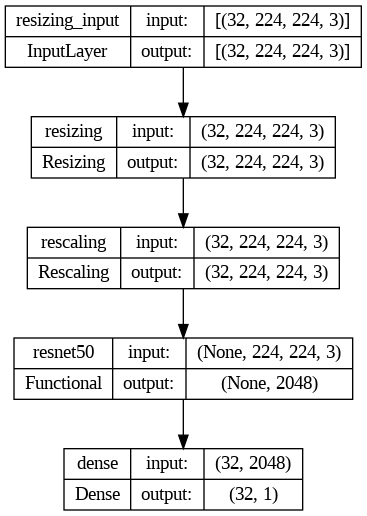

In [ ]:
# If you don't have these installed
#!pip install pydot
#!apt-get install graphviz -y
from tensorflow.keras.utils import plot_model

# Create a diagram of the model architecture
#plot_model(VGG_model, to_file='VGG19model.png', show_shapes=True, show_layer_names=True)
plot_model(model, to_file='Resnet50Model.png', show_shapes=True, show_layer_names=True)
#plot_model(custom_model, to_file='HALNet_1_Model.png', show_shapes=True, show_layer_names=True)
from google.colab import files
files.download('VGG19_model.png')


1/1 [==============================] - 1s 909ms/step


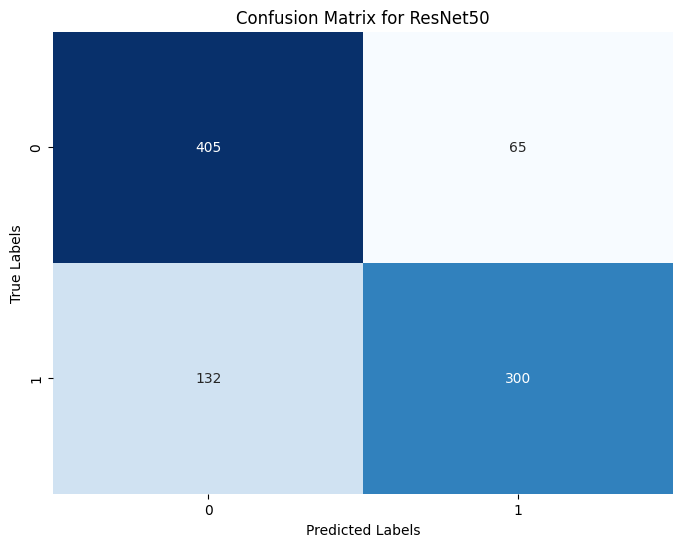

Metrics for ResNet50:
Precision: 0.82
Recall: 0.69
F1 Score: 0.75
------

1/1 [==============================] - 0s 168ms/step


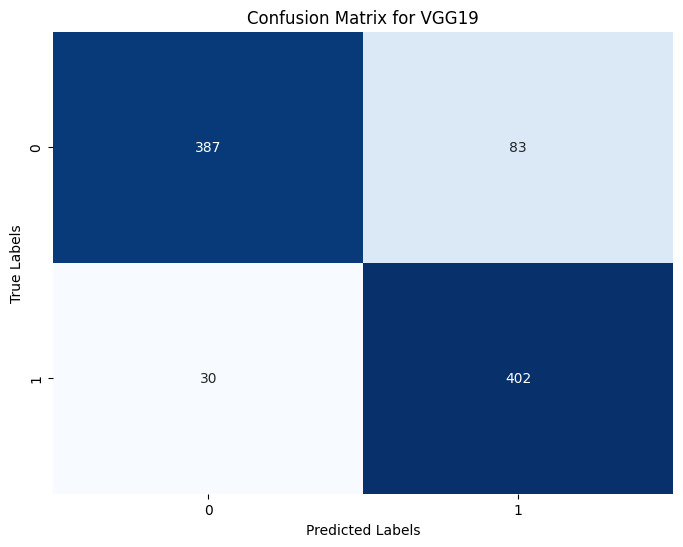

Metrics for VGG19:
Precision: 0.83
Recall: 0.93
F1 Score: 0.88
------

1/1 [==============================] - 0s 86ms/step


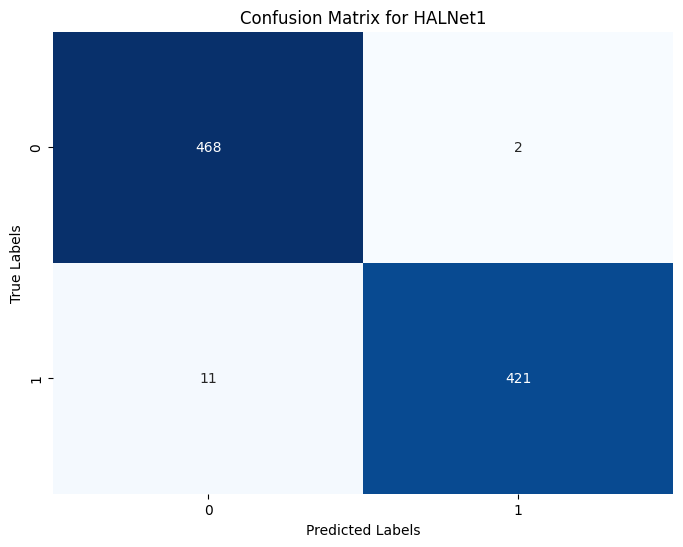

Metrics for HALNet1:
Precision: 1.00
Recall: 0.97
F1 Score: 0.98
------

1/1 [==============================] - 0s 157ms/step


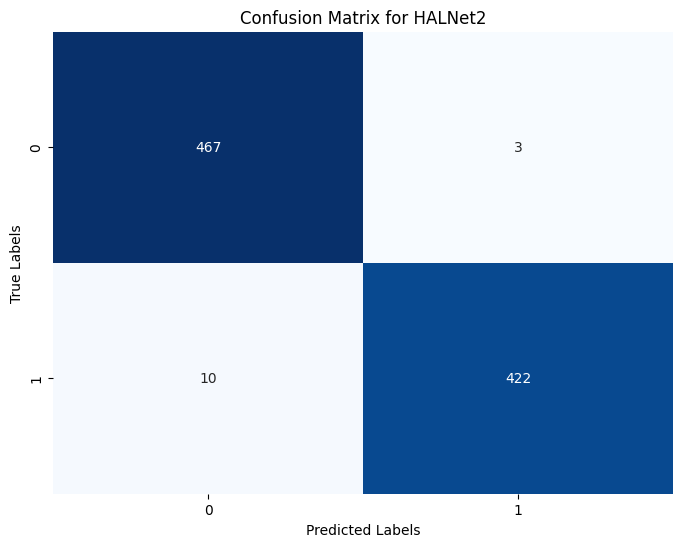

Metrics for HALNet2:
Precision: 0.99
Recall: 0.98
F1 Score: 0.98
------

1/1 [==============================] - 0s 130ms/step


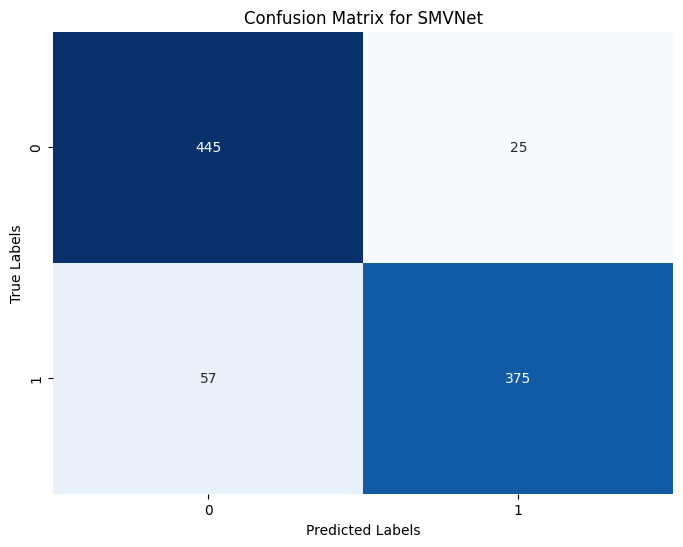

Metrics for SMVNet:
Precision: 0.94
Recall: 0.87
F1 Score: 0.90
------

1/1 [==============================] - 0s 170ms/step


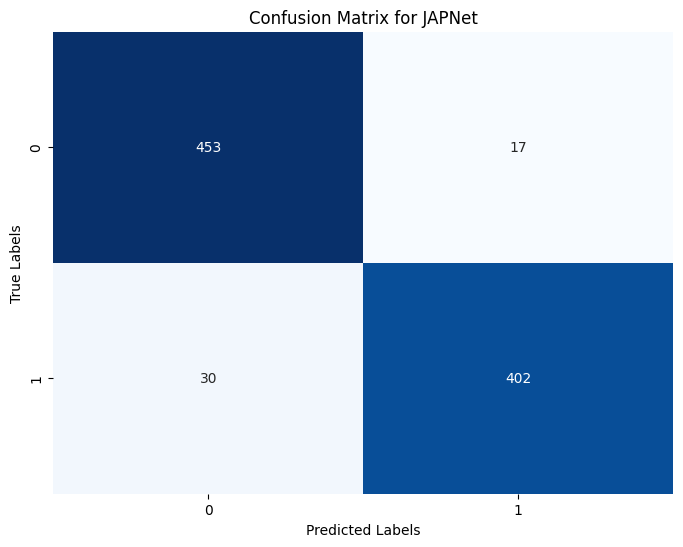

Metrics for JAPNet:
Precision: 0.96
Recall: 0.93
F1 Score: 0.94
------



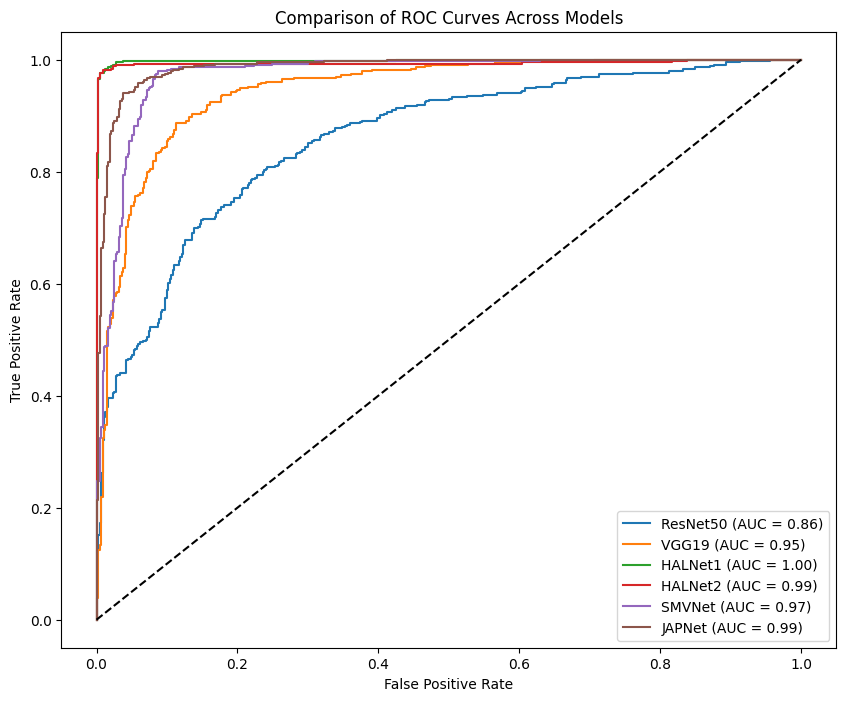

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns

# Model paths and names
models_info = {
    "ResNet50": "/content/drive/MyDrive/Colab Notebooks/Final Codes/Resnet50.h5",
    "VGG19": "/content/drive/MyDrive/Colab Notebooks/Final Codes/VGG19.h5",
    "HALNet1": "/content/drive/MyDrive/Colab Notebooks/Final Codes/HALNet1.h5",
    "HALNet2": "/content/drive/MyDrive/Colab Notebooks/Final Codes/HALNet2.h5",
    "SMVNet": "/content/drive/MyDrive/Colab Notebooks/Final Codes/SMVNet.h5",
    "JAPNet": "/content/drive/MyDrive/Colab Notebooks/Final Codes/JAPnet.h5"
}

# Function to load model and get predictions
def get_model_predictions(model, dataset):
    predictions = []
    labels = []
    for x, y in dataset:
        preds = model.predict(x)
        predictions.extend(preds.flatten())  # Make sure to flatten or adjust depending on model output
        labels.extend(y.numpy())
    return np.array(predictions), np.array(labels)

# Prepare to collect ROC data
roc_data = []

# Process each model
for model_name, model_path in models_info.items():
    # Load the model
    model = load_model(model_path)

    # Get predictions and labels
    predictions, labels = get_model_predictions(model, val_ds)

    threshold = 0.5
    predicted_labels = (predictions > threshold).astype(int)
    # Compute confusion matrix
    cm = confusion_matrix(labels, predicted_labels)
    # Compute other metrics
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predicted_labels, average='binary')
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Print metrics
    print(f"Metrics for {model_name}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")
    print("------\n")


    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(labels, predictions)
    auc = roc_auc_score(labels, predictions)

    # Store the ROC data
    roc_data.append((fpr, tpr, auc, model_name))

# Plot all ROC curves in one figure
plt.figure(figsize=(10, 8))
for fpr, tpr, auc, model_name in roc_data:
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

# Add the random chance line
plt.plot([0, 1], [0, 1], 'k--')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves Across Models')
plt.legend(loc='lower right')
plt.show()
